In [6]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms


# Creating Custom DataSet

In [7]:
class CellImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.labels = []
        self.image_paths = []
        self.transform = transform
        self.class_to_idx = {}

        for idx, class_name in enumerate(os.listdir(img_dir)):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(img_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.labels.append(idx)
                    self.image_paths.append(img_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = read_image(self.image_paths[idx])
        image = transforms.ToPILImage()(image)  # Convert the tensor image to a PIL Image
        if self.transform:
            image = self.transform(image)
        return image, label

# Adapting EficiNet to the Custom DataSet

In [8]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        
        # Get the output dimension of the EfficientNet feature extractor
        efficient_net_output_dim = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Identity()  # Remove the final classification layer

        # Define the combined fully connected layer
        self.fc_combined = nn.Linear(efficient_net_output_dim, num_classes)

    def forward(self, images):
        efficient_net_out = self.efficient_net(images)
        efficient_net_out = torch.flatten(efficient_net_out, 1)
        out = self.fc_combined(efficient_net_out)
        return out

In [9]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Defining Hyperparameters

In [10]:
img_dir = 'partial_sub_images'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = CellImageDataset(img_dir, transform=transform)

# Dividir o dataset em conjuntos de treino e teste mantendo a proporção de classes
train_indices, test_indices = train_test_split(
    range(len(dataset.labels)),
    test_size=0.2,
    random_state=42,
    stratify=dataset.labels
)

train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

# Criar os dataloaders para os conjuntos de treino e teste
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

num_classes = len(dataset.class_to_idx)
model = CustomEfficientNet(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

Loaded pretrained weights for efficientnet-b0
Training on device cpu


# Treinamento do modelo

In [11]:

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader)}")


Epoch 1 - Loss: 0.9600343036651612
Epoch 2 - Loss: 0.4451063370704651
Epoch 3 - Loss: 0.26978312045335767
Epoch 4 - Loss: 0.14211787655949593
Epoch 5 - Loss: 0.16761755846440793
Epoch 6 - Loss: 0.14023838728666305
Epoch 7 - Loss: 0.08278245996683836
Epoch 8 - Loss: 0.05388678127899766
Epoch 9 - Loss: 0.055436396207660436
Epoch 10 - Loss: 0.0951104853861034
Epoch 11 - Loss: 0.11762717455625533
Epoch 12 - Loss: 0.07996384338475764
Epoch 13 - Loss: 0.06847766552120448
Epoch 14 - Loss: 0.02800130147486925
Epoch 15 - Loss: 0.02142346924636513
Epoch 16 - Loss: 0.029486565827392043
Epoch 17 - Loss: 0.028616219637915493
Epoch 18 - Loss: 0.01905607119668275
Epoch 19 - Loss: 0.0303512599831447
Epoch 20 - Loss: 0.12532957536634057
Epoch 21 - Loss: 0.13443679008632897
Epoch 22 - Loss: 0.09098058535717428
Epoch 23 - Loss: 0.061032517971470954
Epoch 24 - Loss: 0.042585284130182116
Epoch 25 - Loss: 0.013667157518211752
Epoch 26 - Loss: 0.026942710595903918
Epoch 27 - Loss: 0.04959957691724412
Epoch 2

In [12]:
    
# Salvar o modelo em um arquivo
torch.save(model.state_dict(), 'custom_eficinet_model_6_categories.pth')

# Avaliação do modelo

Test Loss: 0.9076
Test Accuracy: 0.7449
Test Precision: 0.7872
Test Recall: 0.7449
Test F1 Score: 0.7517


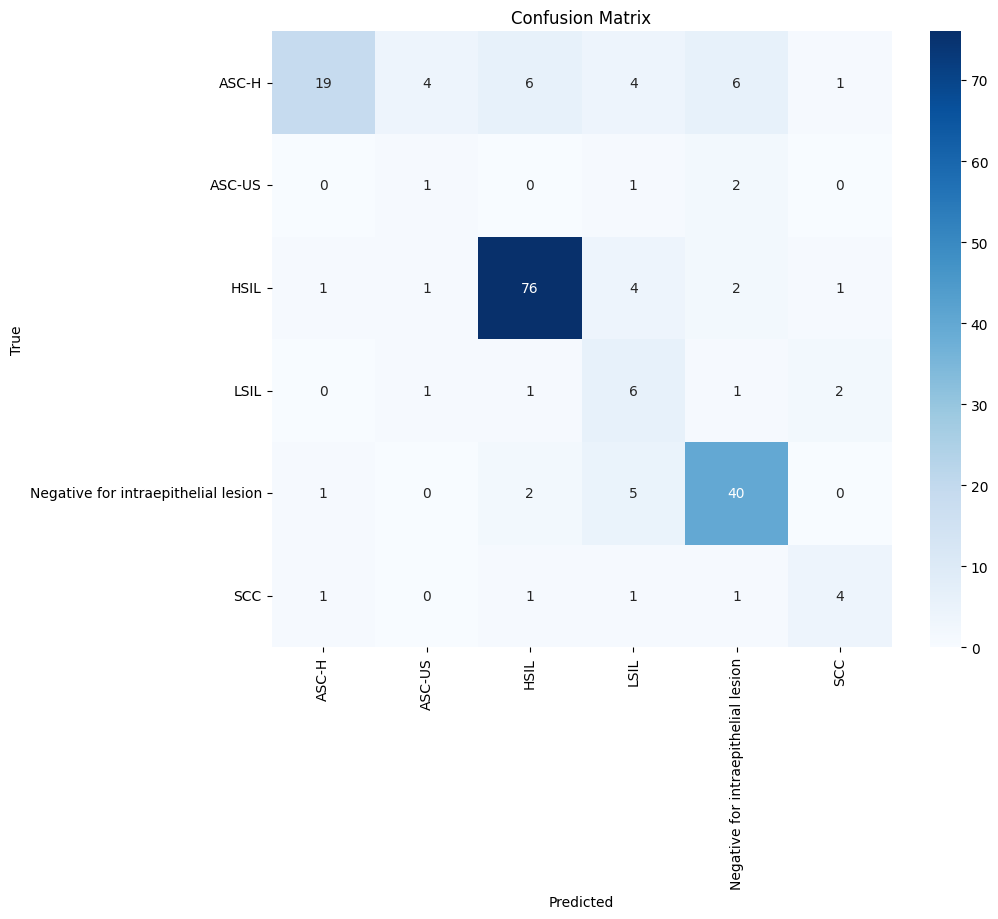

In [13]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Plot da matriz de confusão
plot_confusion_matrix(all_labels, all_preds, list(dataset.class_to_idx.keys()))